# Downlink Channel Estimation using CSI-RS

Type-1 codebook-based downlink precoding and combining for massive MIMO (Multiple Input Multiple Output) in 5G networks refers to a technique used to enhance the efficiency and performance of wireless communication systems, particularly in scenarios with a large number of antennas at the base station.
SVD stands for Singular Value Decomposition, a mathematical technique used to decompose a matrix into three other matrices, which helps in analyzing and manipulating the properties of the original matrix. 

- The first part of the SVD, known as left signular matrix, is used for signal **Combining** at the receiver,
- The third part of the SVD, known as left signular matrix, is used for signal **Precoding** at the transmitter,
- The middle part of the SVD, contains the eigen values which, is used for selection of rank.

In the context of downlink precoding and combining in massive MIMO systems, SVD is applied to the channel matrix to extract the spatial characteristics of the communication channels.

**Type-1 codebook** based precoding is applied to PDSCH data and at the Rx the combiner from SVD has been used

The tutorial is organized as following

- [Import Libraries](#Import-Python-Libraries)

    - [Import Python Libraries](#Import-Python-Libraries)
    - [Import 5G-Toolkit Libraries](#Import-5G-Toolkit-Libraries)
    
- [Simulation Parameters](#Simulation-Parameters)
- [Generate Wireless Channel](#Generate-Wireless-Channel:-CDL-A)
- [CSI Configurations](#CSI-Configurations)

**Key Performance Parameters**
- Throughput vs SNR
- BLER vs SNR
- BER vs SNR

## Import Python Libraries
### Import Python Libraries

In [1]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# %matplotlib widget
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches
import matplotlib as mpl

import numpy      as np
import numpy.matlib
import scipy      as sp
import scipy.io   as spio
import scipy.constants
from   scipy import interpolate

### Import 5G-Toolkit Libraries

In [2]:
import sys
sys.path.append("../../../")


from toolkit5G.ChannelModels      import AntennaArrays, SimulationLayout, ParameterGenerator, ChannelGenerator
from toolkit5G.ResourceMapping    import ResourceMapperCSIRS
from toolkit5G.Configurations     import CSIConfiguration
from toolkit5G.ChannelProcessing  import AddNoise
from toolkit5G.ReceiverAlgorithms import ChannelEstimationCSIRS
from toolkit5G.MIMOProcessing     import TypeICodeBook

## Simulation Parameters

In [3]:
propTerrain      = "UMa"         # Propagation Scenario or Terrain for BS-UE links
carrierFrequency = 3.6*10**9         # Array of two carrier frequencies in GHz
scs              = 30*10**3
Nfft             = 1024
numOfBSs         = 6 # number of BSs
nBSs             = np.prod(numOfBSs)
nUEs             = 11              # number of UEs
numRBs           = 84
numSlots         = 1
bandwidth        = 30*10**6
print()
print("*****************************************************")
print("                   Terrain: "+str(propTerrain))
print("             Number of UEs: "+str(nUEs))
print("             Number of BSs: "+str(numOfBSs))
print("         carrier Frequency: "+str(carrierFrequency/10**9)+" GHz")
print(" Number of Resource Blocks: "+str(numRBs))
print("        Subcarrier Spacing: "+str(scs))
print("                  FFT Size: "+str(Nfft))
print("*****************************************************")
print()


*****************************************************
                   Terrain: UMa
             Number of UEs: 11
             Number of BSs: 6
         carrier Frequency: 3.6 GHz
 Number of Resource Blocks: 84
        Subcarrier Spacing: 30000
                  FFT Size: 1024
*****************************************************



## Generate Channel 

The process of channel generation is as follows:

- Generate Antenna Arrays

    - Generate Antenna Arrays for BSs
    - Generate Antenna Arrays for UEs
    
- Generate Simulation Topology
- Generate Propagation parameters (LSPs | SSPs | Intial random phases)
- Generate Wireless Channel ==> Get OFDM Channel

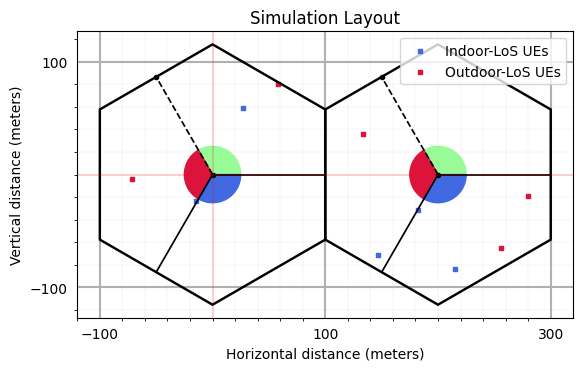

In [4]:
# Antenna Array at UE side
# assuming antenna element type to be "OMNI"
# with 2 panel and 2 single polarized antenna element per panel.
ueAntArray = AntennaArrays(antennaType = "OMNI",  centerFrequency = carrierFrequency, arrayStructure  = np.array([1,1,2,2,2]))
ueAntArray()

# # Radiation Pattern of Rx antenna element
# ueAntArray.displayAntennaRadiationPattern()


# Antenna Array at BS side
# assuming antenna element type to be "3GPP_38.901", a parabolic antenna
# with 4 panel and 4 single polarized antenna element per panel.
bsAntArray = AntennaArrays(antennaType = "3GPP_38.901", centerFrequency = carrierFrequency, arrayStructure  = np.array([1,1,4,4,2]))
bsAntArray()

# # Radiation Pattern of Tx antenna element
# bsAntArray[0].displayAntennaRadiationPattern()

# Layout Parameters
isd                  = 200          # inter site distance
minDist              = 10          # min distance between each UE and BS
ueHt                 = 1.5         # UE height
bsHt                 = 25          # BS height
bslayoutType         = "Hexagonal" # BS layout type
ueDropType           = "Hexagonal" # UE drop type
htDist               = "equal"       # UE height distribution
ueDist               = "random"       # UE Distribution per site
nSectorsPerSite      = 3             # number of sectors per site
maxNumFloors         = 1             # Max number of floors in an indoor object
minNumFloors         = 1             # Min number of floors in an indoor object
heightOfRoom         = 5.1             # height of room or ceiling in meters
indoorUEfract        = 0.5           # Fraction of UEs located indoor
lengthOfIndoorObject = 3             # length of indoor object typically having rectangular geometry
widthOfIndoorObject  = 3             # width of indoor object
forceLOS             = True          # boolen flag if true forces every link to be in LOS state
# forceLOS             = False       # boolen flag if true forces every link to be in LOS state

# simulation layout object
simLayoutObj = SimulationLayout(numOfBS = numOfBSs,
                                numOfUE = nUEs,
                                heightOfBS = bsHt,
                                heightOfUE = ueHt,
                                ISD = isd,
                                layoutType = bslayoutType,
                                layoutWidth = 50,
                                layoutLength = 120,
                                ueDropMethod = ueDropType,
                                UEdistibution = ueDist,
                                UEheightDistribution = htDist,
                                numOfSectorsPerSite = nSectorsPerSite,
                                ueRoute = None)

simLayoutObj(terrain = propTerrain,
             carrierFreq = carrierFrequency,
             ueAntennaArray = ueAntArray,
             bsAntennaArray = bsAntArray,
             indoorUEfraction = indoorUEfract,
             heightOfRoom = heightOfRoom,
             lengthOfIndoorObject = lengthOfIndoorObject,
             widthOfIndoorObject = widthOfIndoorObject,
             forceLOS = forceLOS)

# displaying the topology of simulation layout
fig, ax = simLayoutObj.display2DTopology()


paramGen = simLayoutObj.getParameterGenerator()

# paramGen.displayClusters((0,0,0), rayIndex = 0)
channel = paramGen.getChannel()
Hf      = channel.ofdm(scs, Nfft)[0]

Nt        = bsAntArray.numAntennas # Number of BS Antennas
Nr        = ueAntArray.numAntennas

## CSI Configurations

In [5]:
config = CSIConfiguration(rowIndex = 4, numSlots = nBSs, startPRB = 0, nrofPRBs = numRBs)

subcarrierSpacing = int(np.random.choice([15000, 30000, 60000, 120000, 240000]))
startPRB          = config.startPRB
nrofPRBs          = config.nrofPRBs
numSubcarriers    = 12*(nrofPRBs+startPRB)
Nfft              = config.Nfft

## CSI-RS Resource Configurations___
rowIndex          = config.rowIndex
nrofPorts         = config.nrofPorts
density           = config.density
cdmType           = config.cdmType
betaCSIRS         = config.betaCSIRS

## CSI-RS Parameters__________________________________________
scramblingID      = config.scramblingID
slotNumber        = config.slotNumber
#_____________________________________________________________

## Time and Frequency resources____________________
firstOFDMSymbolInTimeDomain  = config.firstOFDMSymbolInTimeDomain
firstOFDMSymbolInTimeDomain2 = config.firstOFDMSymbolInTimeDomain2
frequencyDomainAllocation    = config.frequencyDomainAllocation

config.display()


                   row-Index: 4
                   nrofPorts: 4
                     density: 1.0
                     cdmType: fd-CDM2
                scramblingID: 599
                  slotNumber: [ 0  8 12  0  0  4]
 firstOFDMSymbolInTimeDomain: 4
firstOFDMSymbolInTimeDomain2: None
   frequencyDomainAllocation: [0 0 1]
                    nrofPRBs: 84
                    startPRB: 0
                        Nfft: 1024
                   betaCSIRS: 1


## Generate CSI-RS Resource Grid

In [6]:
rmCSIRS   = ResourceMapperCSIRS(nrofPorts, density, cdmType, scramblingID, slotNumber,
                                frequencyDomainAllocation, firstOFDMSymbolInTimeDomain,
                                firstOFDMSymbolInTimeDomain2)
csirsGrid = rmCSIRS(nrofPRBs, startPRB, resourceGridSizeinRBs=None, beta = betaCSIRS)

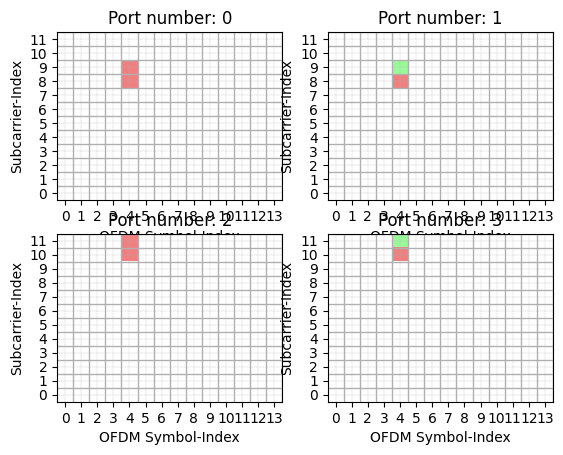

In [7]:
fig, ax = rmCSIRS.displayCDMPattern()

## Generate the Transmit Grid

In [8]:
## Load the resource grid to Transmission Grid
XGrid     = np.zeros((nBSs, nrofPorts, 14, Nfft), dtype=np.complex64)
bwpOffset = np.random.randint(0,Nfft-(startPRB+nrofPRBs)*12)
XGrid[...,bwpOffset:bwpOffset+(startPRB+nrofPRBs)*12] = csirsGrid


print()
print("*****************************************************")
print("      Size of the Transmission Grid:  "+str(XGrid.shape))
print("         BWP Resoure Element Offset:  "+str(startPRB))
print("      Size of the CSIRS-Resource Grid:  "+str(csirsGrid.shape))
print("*****************************************************")
print()



*****************************************************
      Size of the Transmission Grid:  (6, 4, 14, 1024)
         BWP Resoure Element Offset:  0
      Size of the CSIRS-Resource Grid:  (6, 4, 14, 1008)
*****************************************************



## Transmit Beamforming

In [9]:
#################################################################
# Beamforming angles
# Inter-element spacing in vertical and horizontal
Pt_dBm= 53
Pt    = 10**(0.1*(Pt_dBm-30))
lamda = 3*10**8/carrierFrequency
d     = 0.5/lamda
theta = 0
# Wt    = np.sqrt(Pt/Nt)*np.exp(1j*2*np.pi*d*np.cos(theta)/(lamda*Nt)*np.arange(0,Nt))
# Xf    = Wt.reshape(-1,1,1)*XGrid1
if(Nt%nrofPorts != 0):
    raise ValueError("'Nt' must be a multiple of 'nrofPorts'!")

rep   = int(Nt/nrofPorts)
# Xf    = np.sqrt(4*Pt/Nt)*XGrid.repeat(rep, axis = 1)
Xf    = XGrid.repeat(rep, axis = 1)

print(" Beamformed Grid: "+str(Xf.shape))

 Beamformed Grid: (6, 32, 14, 1024)


## Pass through the Channel

In [10]:
Y = (Hf[0,:,:,np.newaxis]@Xf.transpose(0,2,3,1)[:,np.newaxis,...,np.newaxis])[...,0]

print()
print("*****************************************************")
print("          Size of the Channel: "+str(Hf.shape))
print("Size of the Transmited Signal: "+str(Xf.shape))
print("  Size of the Received Signal: "+str(Y.shape))
print("*****************************************************")
print()


*****************************************************
          Size of the Channel: (1, 6, 11, 1024, 8, 32)
Size of the Transmited Signal: (6, 32, 14, 1024)
  Size of the Received Signal: (6, 11, 14, 1024, 8)
*****************************************************



## Add noise at Receiver

In [11]:
BoltzmanConst = 1.380649*(10**(-23))
temperature   = 300
noiseFiguredBi= 7
noiseFigure   = 10**(noiseFiguredBi/10)
noisePower    = BoltzmanConst*temperature*bandwidth/noiseFigure
noisePower    = 0
kppm          = 0
fCFO          = kppm*(np.random.rand()-0.5)*carrierFrequency*(10**(-6)); # fCFO = CFO*subcarrierSpacing
CFO           = (fCFO/scs)/Nfft
##Yf            = AddNoise(True)(Y, noisePower, CFO)

Yf            = AddNoise(False)(Y, noisePower, 0)    #Added

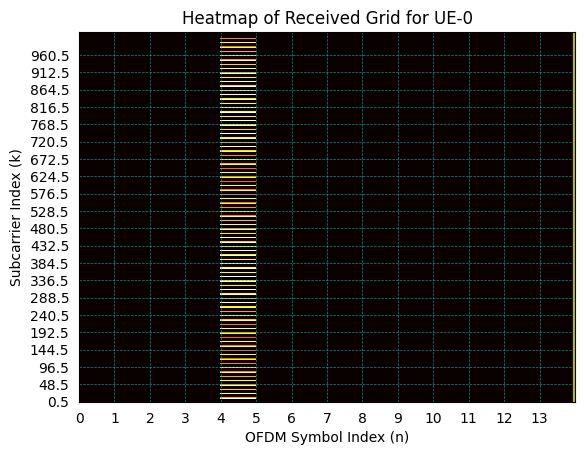

In [12]:
# Plot Resource Grid
#################################################################
bsIndex = 0
ueIndex = 0
fig, ax = plt.subplots()
colors  = ['palegreen', 'white', 'lightcoral', 'gold', 'midnightblue', 'purple']
bounds  = [-1, 0, 1, 2, 3, 4, 5]

cmap    = mpl.colors.ListedColormap(colors)
norm    = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax.pcolor(np.abs(Yf[bsIndex, ueIndex,...,0].T), cmap = "hot")
ax.axvline(x=14, color = 'y', lw = 3)
ax.set_yticks(np.arange(0.5, 12*numRBs, 48), minor=False);
# ax.set_yticks(np.arange(0, 12, 1), minor=False);
# ax.set_xticks(np.arange(0.5, 14*numSlots, 1), minor=True);
ax.set_xticks(np.arange(0, 14*numSlots, 1), minor=False);
# ax.tick_params(axis='both',which='minor', grid_linewidth=2, width=0)
ax.tick_params(axis='both',which='major', grid_alpha = 0.75, 
               grid_linewidth=0.05, width=0, grid_linestyle = '--')
ax.set_xlabel("OFDM Symbol Index (n)")
ax.set_ylabel("Subcarrier Index (k)")
ax.set_title("Heatmap of Received Grid for UE-"+str(ueIndex))
ax = plt.gca()
ax.grid(color='c', linestyle='--', linewidth=0.5)
# Gridlines based on minor ticks
plt.show()

## Extract the Resource Grid

In [13]:
rxGrid = Yf[...,bwpOffset:bwpOffset+12*nrofPRBs,:]

print("  Size of the Received Signal: "+str(rxGrid.shape))

  Size of the Received Signal: (6, 11, 14, 1008, 8)


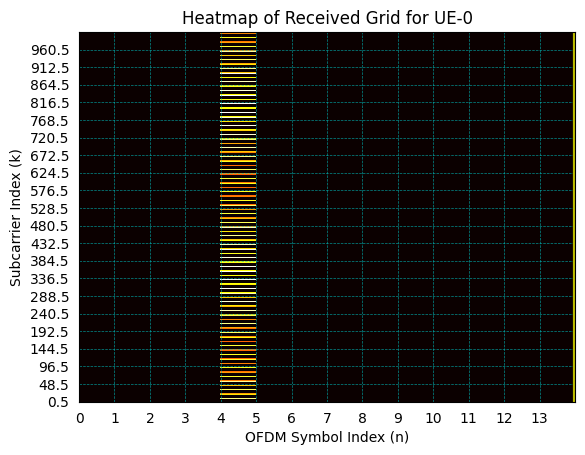

In [14]:
# Plot Resource Grid
#################################################################
bsIndex = 0
ueIndex = 0
fig, ax = plt.subplots()
colors  = ['palegreen', 'white', 'lightcoral', 'gold', 'midnightblue', 'purple']
bounds  = [-1, 0, 1, 2, 3, 4, 5]

cmap    = mpl.colors.ListedColormap(colors)
norm    = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax.pcolor(np.abs(rxGrid[bsIndex, ueIndex,...,0].T), cmap = "hot")
ax.axvline(x=14, color = 'y', lw = 3)
ax.set_yticks(np.arange(0.5, 12*numRBs, 48), minor=False);
# ax.set_yticks(np.arange(0, 12, 1), minor=False);
# ax.set_xticks(np.arange(0.5, 14*numSlots, 1), minor=True);
ax.set_xticks(np.arange(0, 14*numSlots, 1), minor=False);
# ax.tick_params(axis='both',which='minor', grid_linewidth=2, width=0)
ax.tick_params(axis='both',which='major', grid_alpha = 0.75, 
               grid_linewidth=0.05, width=0, grid_linestyle = '--')
ax.set_xlabel("OFDM Symbol Index (n)")
ax.set_ylabel("Subcarrier Index (k)")
ax.set_title("Heatmap of Received Grid for UE-"+str(ueIndex))
ax = plt.gca()
ax.grid(color='c', linestyle='--', linewidth=0.5)
# Gridlines based on minor ticks
plt.show()

## Estimate the Channel using CSI-RS

In [15]:
interpolatorType = np.random.choice(["disabled","NN","Linear","Cubic","Spline","Akima","Pchip", "Spline_and_Denoise"])
interpolatorType = "Linear"
print("Interpolator: "+interpolatorType)
chEst = ChannelEstimationCSIRS()
Hfest = np.zeros((nBSs, nUEs, Nr, nrofPorts, 14, 12*nrofPRBs), dtype=np.complex64)
for nue in range(nUEs):
        print("nue: "+str((nue)))
        Hfest[:,nue] = chEst(rxGrid[:,nue].transpose(0,3,1,2), rmCSIRS, interpolatorType = interpolatorType, order = 5, knots=None, lamda=None)


Interpolator: Linear
nue: 0
nue: 1
nue: 2
nue: 3
nue: 4
nue: 5
nue: 6
nue: 7
nue: 8
nue: 9
nue: 10


### Display the Estimated channel

In [16]:
txAntIdx = -1

txAntIdx: 0


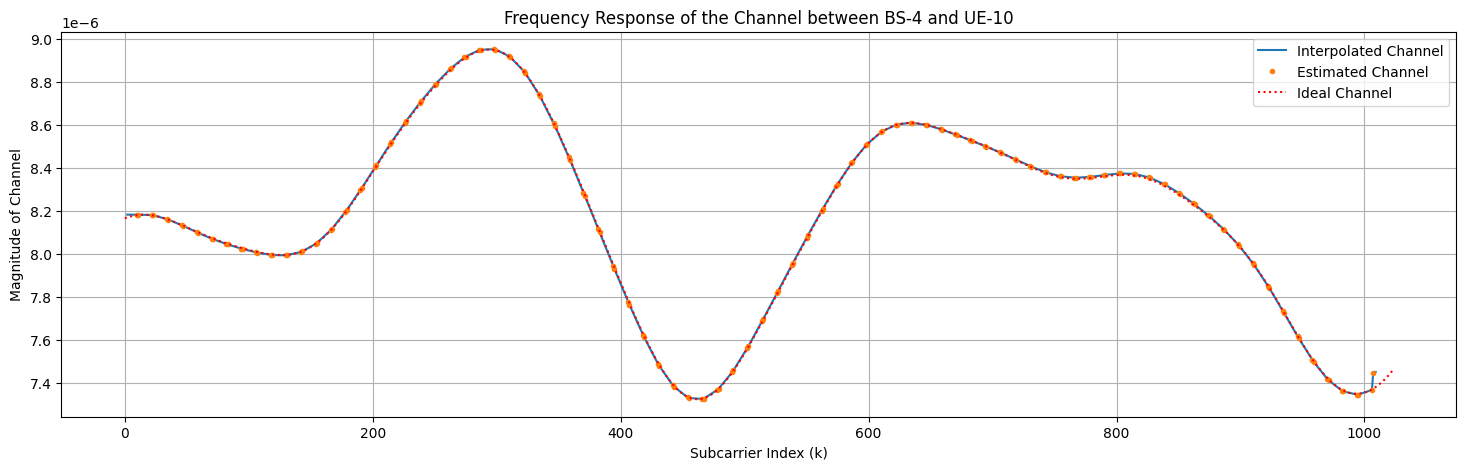

In [17]:
bsIndex   = np.random.randint(nBSs)
ueIndex   = np.random.randint(nUEs)
rxAntIdx  = np.random.randint(Nr)
# txAntIdx  = np.random.randint(nrofPorts)
txAntIdx  = txAntIdx + 1

print("txAntIdx: "+str(txAntIdx))
symbIndex = rmCSIRS.ofdmSymbolNumber[0]
Hideal    = np.abs(Hf[0,bsIndex, ueIndex][:,rxAntIdx,:].reshape(Nfft, nrofPorts,-1).sum(-1))[...,txAntIdx]
Hest      = np.abs(Hfest[bsIndex, ueIndex, rxAntIdx, txAntIdx, symbIndex])
# Hest      = np.where(np.isnan(Hest), 0, Hest)
i         = 5
scale     = Hideal[bwpOffset+rmCSIRS.subcarrierIndices[txAntIdx,0,i]]/Hest[rmCSIRS.subcarrierIndices[txAntIdx,0,i]]
# scale     = 1
fig, ax = plt.subplots(figsize=(18,5))

if (rmCSIRS.nrofPorts == 1):
    ax.plot(np.arange(bwpOffset, bwpOffset+12*numRBs), Hest, label = "Interpolated Channel")
    ax.plot(bwpOffset+rmCSIRS.subcarrierIndices[0,0],  Hest[rmCSIRS.subcarrierIndices[0,0]], ".", label = "Estimated Channel")
    ax.plot(np.arange(0, Nfft, 1), np.abs(Hf[0,bsIndex, ueIndex][:,rxAntIdx,:].sum(-1)), "r:", label = "Ideal Channel")
    
elif (rmCSIRS.nrofPorts == 2):
    ax.plot(np.arange(bwpOffset, bwpOffset+12*numRBs), scale*Hest, label = "Interpolated Channel")
    ax.plot(bwpOffset+rmCSIRS.subcarrierIndices[0,0],  scale*Hest[rmCSIRS.subcarrierIndices[0,0]], ".", label = "Estimated Channel")
    ax.plot(np.arange(0, Nfft, 1), Hideal, "r:", label = "Ideal Channel")
    
elif (rmCSIRS.rowIndex in [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]):
    ax.plot(np.arange(bwpOffset, bwpOffset+12*numRBs), scale*Hest, label = "Interpolated Channel")
    ax.plot(bwpOffset+rmCSIRS.subcarrierIndices[txAntIdx,0],  scale*Hest[rmCSIRS.subcarrierIndices[txAntIdx,0]], ".", label = "Estimated Channel")
    ax.plot(np.arange(0, Nfft), Hideal, "r:", label = "Ideal Channel")
    
ax.legend(loc = 'best')
ax.set_xlabel("Subcarrier Index (k)")
ax.set_ylabel("Magnitude of Channel")
ax.set_title("Frequency Response of the Channel between BS-"+str(bsIndex)+" and UE-"+str(ueIndex))
# ax.set_ylim([0.0000285,0.0000325])
ax.grid()
plt.show()


## Estimate the Rank and Condition number

In [18]:
maxRank = 8 # max rank that Type-I pRECODING
rank = np.random.randint(1,np.min([Nr,Nt,maxRank]), size = (nUEs,nBSs))
rank

array([[5, 3, 2, 5, 1, 5],
       [3, 2, 1, 6, 7, 3],
       [7, 2, 4, 1, 7, 1],
       [6, 3, 3, 4, 3, 1],
       [1, 3, 7, 4, 6, 2],
       [5, 7, 2, 1, 2, 4],
       [1, 4, 5, 4, 2, 2],
       [5, 3, 2, 2, 4, 4],
       [6, 1, 7, 4, 1, 7],
       [6, 5, 1, 3, 4, 7],
       [5, 2, 6, 1, 2, 3]])

In [19]:
rank = 2

## SVD of Channel and Condition number

In [20]:
[U, S, Vh] = np.linalg.svd(Hf)
condition_number = np.max(S, axis = -1)/np.min(S, axis = -1)

In [21]:
condition_number.shape

(1, 6, 11, 1024)

## Estimate the Precoder: Type-I

In [22]:
# Specifying the sub-band size

subBandSize      = 8 # sub-band size in PRBs
numSubBands      = int(numRBs/subBandSize) # number of sub-band channels
subBandSCIndices = np.arange(bwpOffset, bwpOffset + numSubBands*subBandSize*12).reshape(numSubBands,-1) # Sub-Carrier indices corresponding to each sub-band
   

##########################################################
# Single Panel Mode 1, Mode 2 : Valid Ranks are 1 and 2
# Single Panel Mode 1-2       : Valid Ranks are 3,4,5,6,7,8
# Multi Panel Mode 1, Mode 2  : Valid Ranks are 1,2,3,4 
##########################################################
codebookType        = "typeI-SinglePanel"
AntennaStructure    = bsAntArray.arrayStructure[-3:-1]
AntennaPolarization = bsAntArray.arrayStructure[-1]

if rank == 1 or rank == 2:
    codebookMode = "1"
else:
    codebookMode = "1-2"

method              = "SearchFree"
numIterations       =  100

type1CB  = TypeICodeBook(codebookType, AntennaStructure, AntennaPolarization)
numPorts = np.prod(AntennaStructure)*AntennaPolarization
type1Precoder = np.zeros((Nfft,numPorts,rank), dtype="complex_")

for nsb in range(numSubBands):
    Hk       = Hf[...,subBandSCIndices[nsb],:,:]
    H        = (np.conj(Hk.transpose(0,1,2,3,5,4))@Hk).mean(-3)
    [S2, V]  = np.linalg.eig(H)
    type1Precoder[subBandSCIndices[nsb],...]  = type1CB(numIterations,V[0,0,0,:,0:rank], rank, codebookMode, method)